In [62]:
# imports
import math
import itertools as it
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

True
True


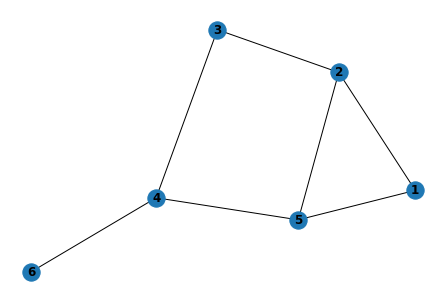

In [63]:
# set up demo graph
n = 6
G_A = nx.Graph()
Ef_A = nx.Graph()
P_A = nx.complete_graph(range(1,n+1))
#
G_A.add_nodes_from(range(1,n+1))
G_A.add_edges_from(((4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2)))
e1 = (5,4)
e2 = (4,5)
f1 = e1 in P_A.edges()
f2 = e2 in P_A.edges()

print(f1)
print(f2)
#P_A.remove_edge(*e)
#f1 = e in P_A.edges()
#print(f1)

#display
nx.draw(G_A, with_labels=True, font_weight='bold')
plt.show()


In [64]:
# larger neighborhood should be Ni (line 6 in DKAS)
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

In [65]:
# mostly as written in DASG paper
# page 8, lines 10-20
def assign_weight_k1(i,j,G_A,P_A):
    e = (i,j)
    if e in P_A.edges():
        if G_A.degree(i) > G_A.degree(j):
            return -2*(G_A.degree(i) - G_A.degree(j))
        elif G_A.degree(j) > G_A.degree(j):
            return -2*(G_A.degree(j) - G_A.degree(i))
        else:
            return -abs(G_A.degree(i) - G_A.degree(j))
    else:
        return -math.inf
    

In [66]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [67]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

In [68]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

In [69]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    print("1: neighbors")
    print(N_i)
    print(N_j)
    try:
        N_i.remove(j)
        N_j.remove(i)
    except(ValueError,TypeError,KeyError):
        print("")
    Ni,Nj = sortByLength(N_i,N_j)
    print("2: remove duplicates")
    print(Ni)
    print(Nj)
    #remove duplicates
    duplicates = Ni.intersection(Nj)
    for d in duplicates:
        Ni.remove(d)
        Nj.remove(d)

    return Ni,Nj

In [70]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
    
    CostMatrix = nx.Graph()
    Ni = []
    Nj = []
    xi = []
    xj = []
    
    print(_Ni_int)
    print(_Nj_int)
    
# make vertices
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=j,value=f)

# # lines 8-9
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
# # larger set xi goes in right partition of graph
    for xe in range(1,degDiff+k_A+1):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=i)#,value=-1)
    for xf in range(1,k_A+1):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=j)#,value=-1)
    l,r = bipartite.sets(CostMatrix)
    print(l)
    print(r)
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value')
    parent = nx.get_node_attributes(CostMatrix,'parent')
# # vertex to vertex
    V2V = [(*e0,assign_weight_k1(value[e0[0]],value[e0[1]],G_A,P_A)) for e0 in it.product(Ni,Nj)]
# # vertex to dummy
    D2V = [(*e1,assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)) for e1 in it.product(xi,Nj)]
    V2D = [(*e2,assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)) for e2 in it.product(Ni,xj)]
# # dummy to dummy
    D2D = [(*e3,0) for e3 in it.product(xj,xi)]

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
    return CostMatrix 

In [71]:
#initialize
k_A = 1
i = 1
j = 2
p_a = DegreeDiffElim(G_A,P_A,k_A)
cm = BuildCostMatrix(i,j,G_A,p_a,Ef_A,k_A)
l, r = bipartite.sets(cm)
print(l)
print(r)
pos = dict()
pos.update( (nn, (1, ii)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
pos.update( (nn, (2, ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
nx.draw(cm, pos=pos,with_labels=True)

#edge weights
labels = nx.get_edge_attributes(cm, "weight")
nx.draw_networkx_edge_labels(cm, pos=pos, edge_labels=labels)
plt.show()

1: neighbors
{2, 5}
{1, 3, 5}
2: remove duplicates
{3, 5}
{5}
{3}
set()


AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.